<a href="https://colab.research.google.com/github/ArielaLevkov/ImageProcessing_TA/blob/main/recitations/05_Recitation_ImageProcessingRecitation_GaussianNoiseReduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import requests
from io import BytesIO
import numpy as np
import matplotlib.pyplot as plt
import PIL
from scipy.signal import convolve

In [ ]:
GITHUB_PATH = 'https://raw.githubusercontent.com/ArielaLevkov/ImageProcessing_TA/main/images/'

def read_file(fname:str, file_path:str=GITHUB_PATH) -> np.ndarray:
    '''
    Accept an image file name (defaulty located in GitHub) and return the image
    in a numpy array.

    Args:
        fname: the file name
        file_path: the file path.. Default value is Doron's Github repo.

    Returns:
        the image converted into a Numpy array.
    '''
    file_path = os.path.join(file_path, fname)
    response = requests.get(file_path)
    fp = BytesIO(response.content)

    img_pil = PIL.Image.open(fp)
    return np.array(img_pil, dtype='int16')

In [ ]:
def plot_images(img1:np.array, img2:np.array):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
    axes[0].imshow(img1,  cmap='gray')
    axes[1].imshow(img2,  cmap='gray')

In [ ]:
def plot_images1(img1:np.array, img2:np.array, img3:np.array):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))
    axes[0].imshow(img1,  cmap='gray')
    axes[1].imshow(img2,  cmap='gray')
    axes[2].imshow(img3,  cmap='gray')

<div dir="rtl">

## 5. הפחתת רעש
<dir>

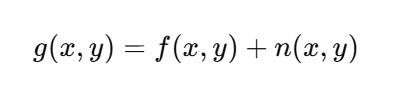

<div dir="rtl">

## 5.1 רעש גאוסיוני:
<dir>

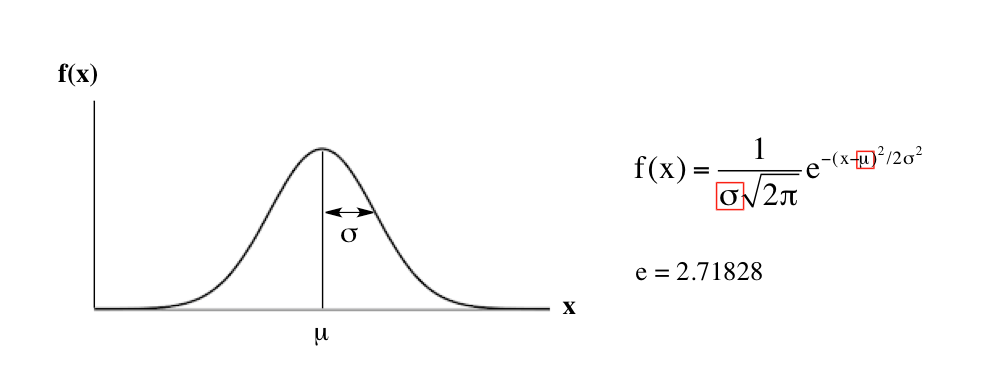

$$I^{'}(x,y)=I(x,y)+f(\mu,\sigma)$$

<div dir="rtl">

#רעש גאוסי בתמונה דיגטלית:
מקורות:
* רעש מהחיישן - במיוחד כאשר התאורה חלשה, החיישן מגביר את האות והגבר מוסיף רעש
* טמפרטורה גבוהה - ככל שהטמפרטורה עולה, הריכיבים האלקטרונים יוצרים פעילות תרמית שמגבירה את הרעש.
* רעש מהמעגל החשמלי - בכל שלב ברכישת התמונה מהאור -> חיישן -> מגבר -> ADC -> עיבוד -> זיכרון מתווסף רעש קטן.

בתמונה דיגיטלית נניח שהתוחלת היא 0 - כלומר אין שינוי בבהירות הממוצעת של התמונה.
<dir>

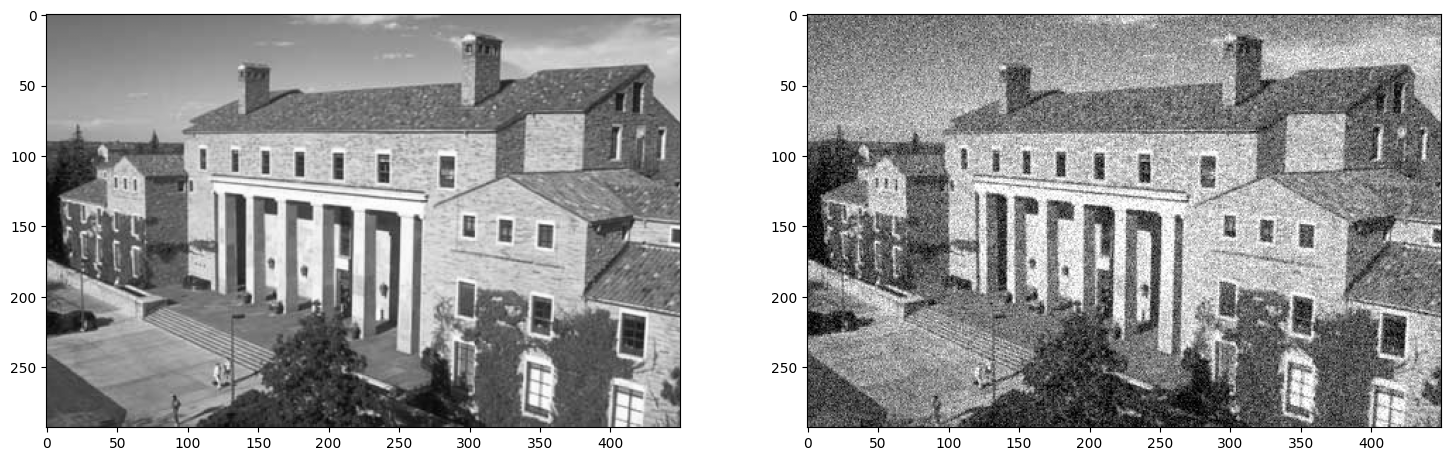

In [ ]:
img = read_file(fname='house.tiff') / 255

img1 = img.copy()
nrows, ncols = img1.shape
for r in range(nrows):
    for c in range(ncols):
        img1[r,c] += np.random.normal(0.0, 0.1)
img1 = np.clip(img1, a_min=0.0, a_max=1.0)
plot_images(img, img1)

<div dir="rtl">

**שימו לב:** בגלל שהוספנו רעש, חלק מהפיקסלים יכולים להיות מתחת ל0 או לעלות מעל 1 ולכן נוסיף .clip
<dir>


<div dir="rtl">

מה יקרה אם נגדיל את סטיית התקן?
<dir>


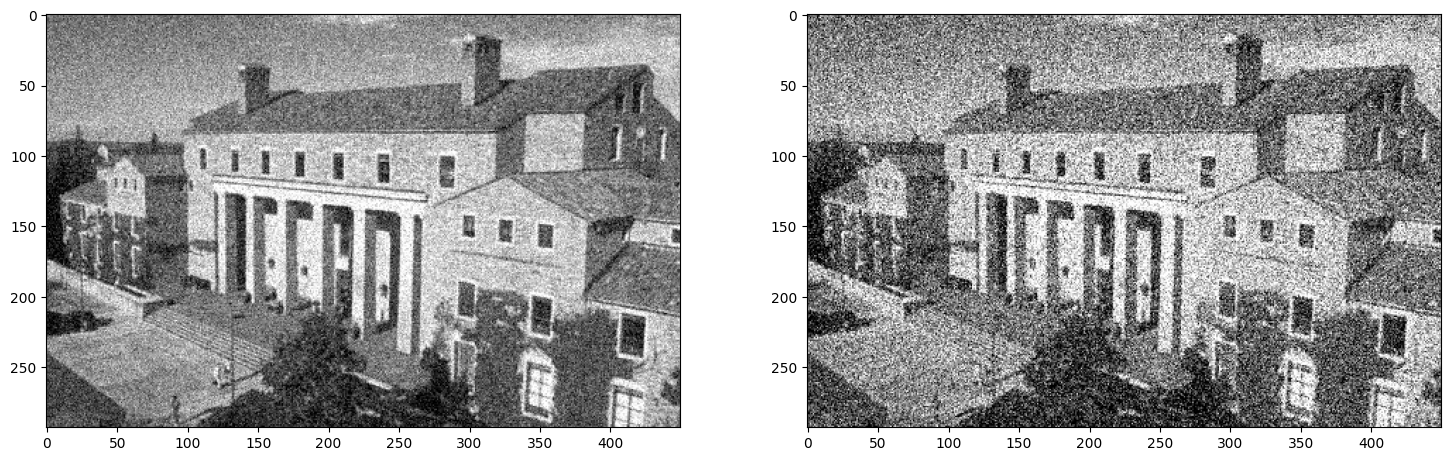

In [ ]:
img2 = img.copy()
nrows, ncols = img2.shape
for r in range(nrows):
    for c in range(ncols):
        img2[r,c] += np.random.normal(0.0, 0.2)
img2 = np.clip(img2, a_min=0.0, a_max=1.0)
plot_images(img1, img2)

<div dir="rtl">

כעת יותר פיקסלים הגיעו לטווח הקצה והפכו לשחור/לבן.
<dir>


<div dir="rtl">

## 5.2 מסננים (החלקה):
<dir>

<div dir="rtl">

תזכורת לקונבלוציה 2D:
<dir>


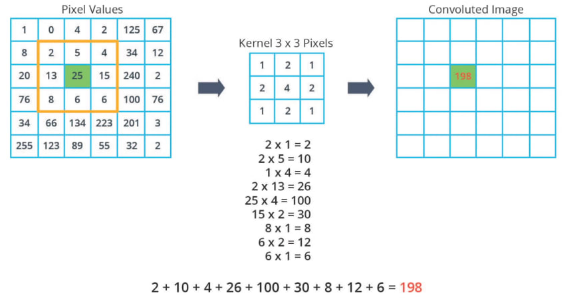

<div dir="rtl">

# 5.2.1 מסנן ממוצע:
<dir>



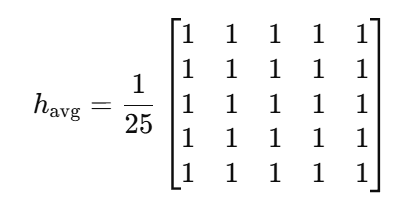

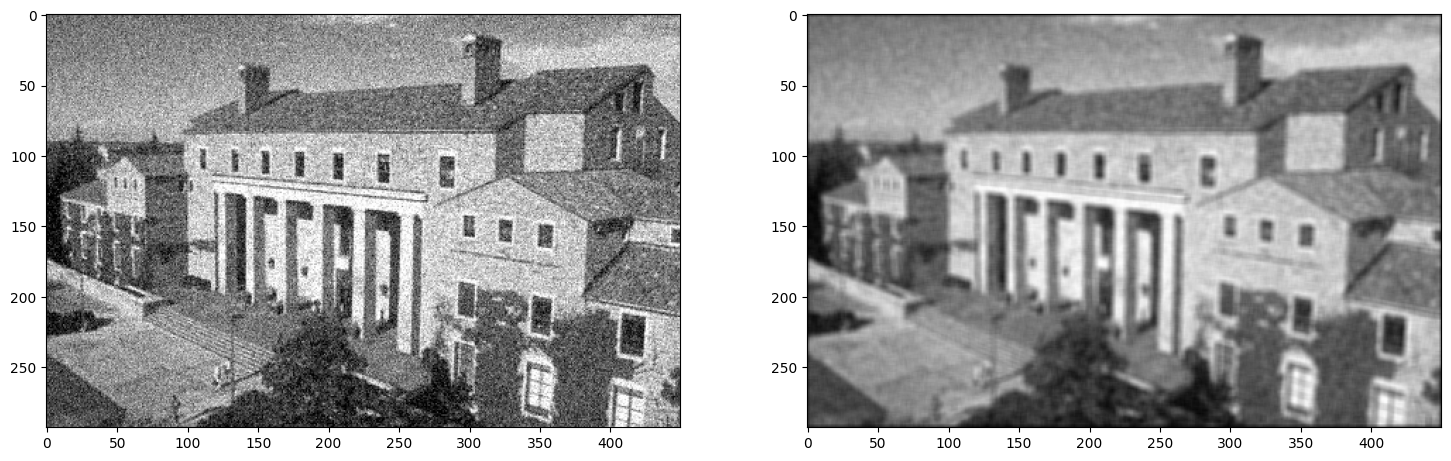

In [ ]:
FILTER_SIZE = 5
filter=np.ones(shape=(FILTER_SIZE, FILTER_SIZE)) / (FILTER_SIZE**2)
img2 = convolve(in1=img1, in2=filter, mode='same')

plot_images(img1, img2)

<div dir="rtl">

# 5.2.2 מסנן גאוסי:

שיטה להקטנת רעש גאוסי ע"י קונבולוציה עם פילטר גאוסי.

הפילטר הגאוסי  הוא מטריצה קטנה (למשל 3×3) שבה הערכים גדולים יותר במרכז וקטנים בקצוות  כמו פעמון דו ממדי.
<dir>



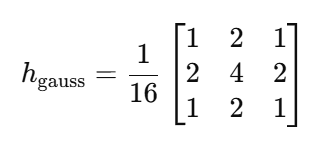

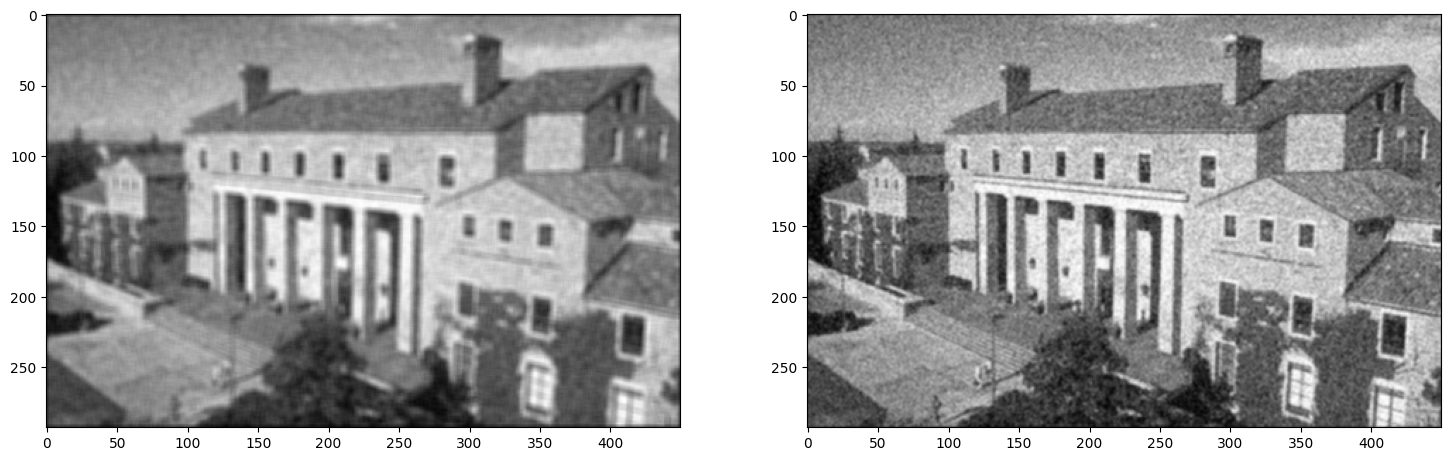

In [ ]:
filter = np.array([[1,2,1],
                   [2,4,2],
                   [1,2,1]])
filter = filter / filter.sum()
img3 = convolve(in1=img1, in2=filter, mode='same')

plot_images(img2, img3)

<div dir="rtl">

# 5.2.3 מסנן כיווני (החלקה כיוונית):
הבעיה בשני המסננים הקודמים היא שהם לא מבחינים בין רעש לקצוות ולכן במקומות שיש קפיצה גדולה ההחלקה פוגעת בניגודיות.

לכן נשתמש במסנן כיווני:

במקום להחליק בכל הכיוונים, המסנן יחליק רק בכיוון שבו יש הכי מעט שינויים בתמונה.
<dir>



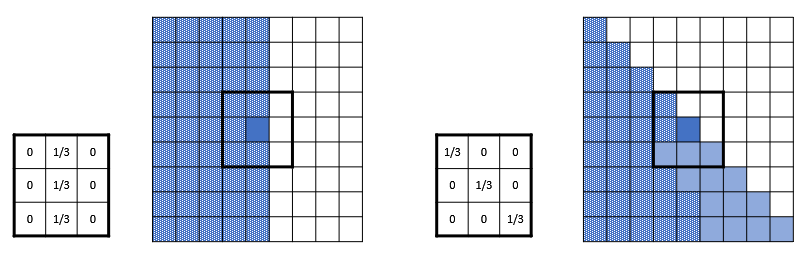

<div dir="rtl">

1. ניצור n מסכות בכיוונים שונים (בדוגמה מתחת 5)
2. עבור כל מסכה נבצע קונבולציה וניצור n תמונות חדשות
3. עוברים על כל הפיקסלים, אחד בכל פעם ובודקים את ההבדל בין פיקסל המקור $I(x,y)$, והפיקסל החדש לאחר הקונבולוציה, $I_j^{'}(x,y)$, ובחורים את האחד הכי קרוב לפי: $|I(x,y)-I_j^{'}(x,y)|$.
<dir>



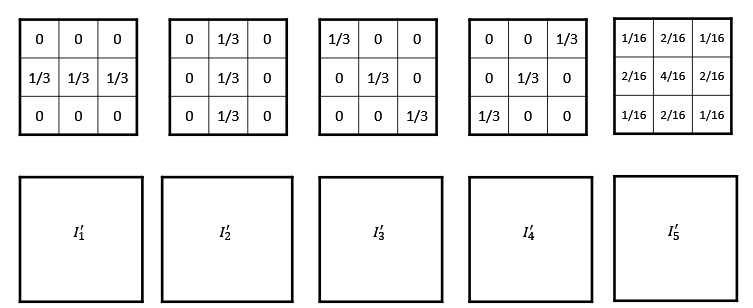

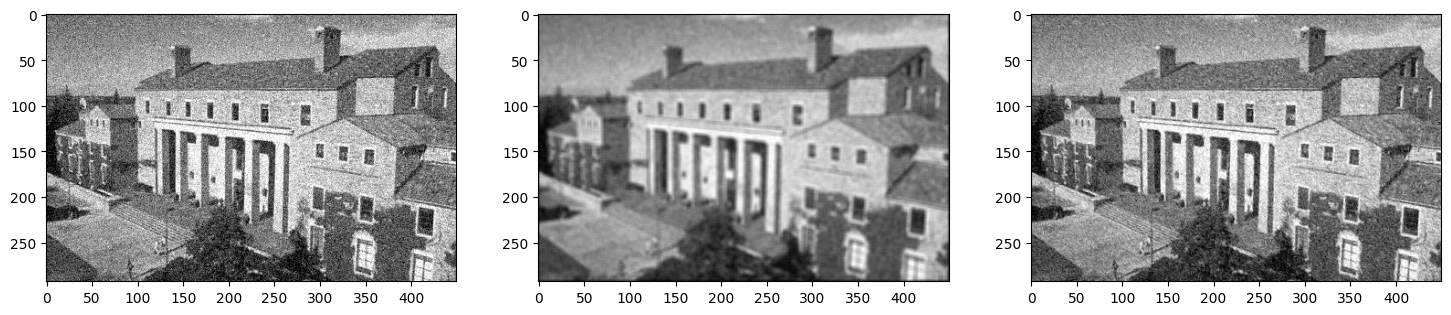

In [ ]:
mask1 = np.array([[0,0,0],
                  [1,1,1],
                  [0,0,0]]) / 3
mask2 = mask1.T
mask3 = np.eye(3) / 3

conv1 = convolve(in1=img1, in2=mask1, mode="same")
conv2 = convolve(in1=img1, in2=mask2, mode="same")
conv3 = convolve(in1=img1, in2=mask3, mode="same")
nrows, ncols = img1.shape
img_e = np.zeros((nrows, ncols))
for r in range(nrows):
    for c in range(ncols):
        convs = [conv1[r,c], conv2[r,c], conv3[r,c]]
        dists = abs(convs - img1[r,c])
        min_ind = dists.argmin()
        img_e[r, c] = convs[min_ind]
plot_images1(img1, img2, img_e)

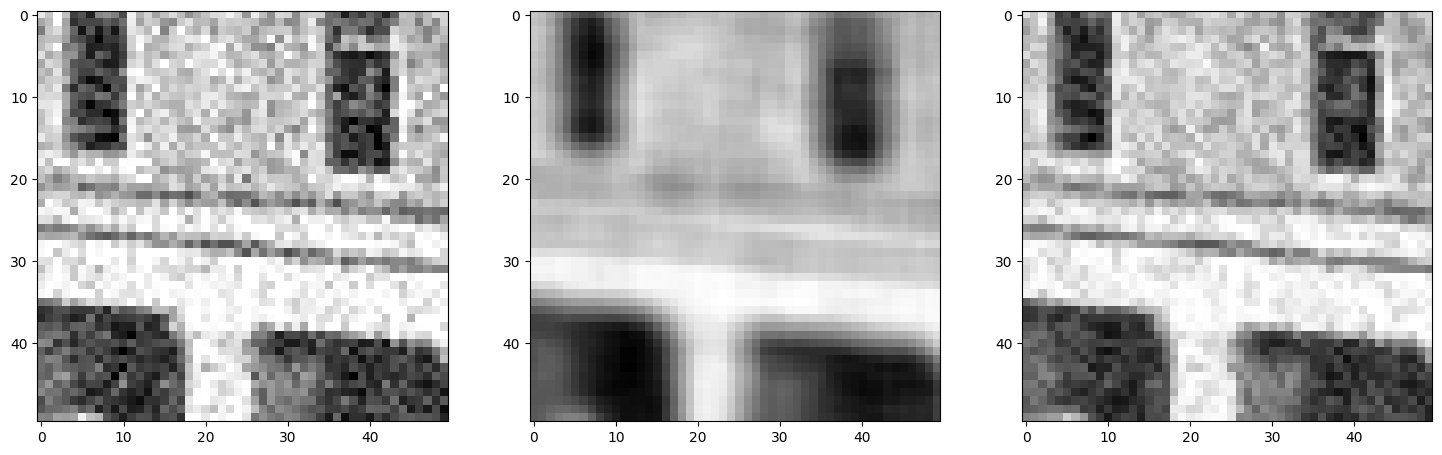

In [ ]:
r0, r1 = 100, 150
c0, c1 = 200, 250

crop_noisy = img1[r0:r1, c0:c1]
crop_gaussian = img2[r0:r1, c0:c1]
crop_directional = img_e[r0:r1, c0:c1]

plot_images1(crop_noisy, crop_gaussian, crop_directional)

<div dir="rtl">

**שימו לב:** יותר מידי מסכות יכולים לגרום ל**התאמת יתר**.

כלומר המערכת תחפש בכוח מסכה שמתאימה רק לרעש, ולא לאות האמיתי.



<div dir="rtl">

# 5.3 מסכה תקינה:
* כל הערכים לא שליליים
* סכום המשקלים חיובי ומנורמל
* המסכה מבצעת החלקה אמיתית
* סימטריה לאורך הכיוון - שמירה על מסכה גיאומטרית סימטרית
* בלי קפיצות חדות


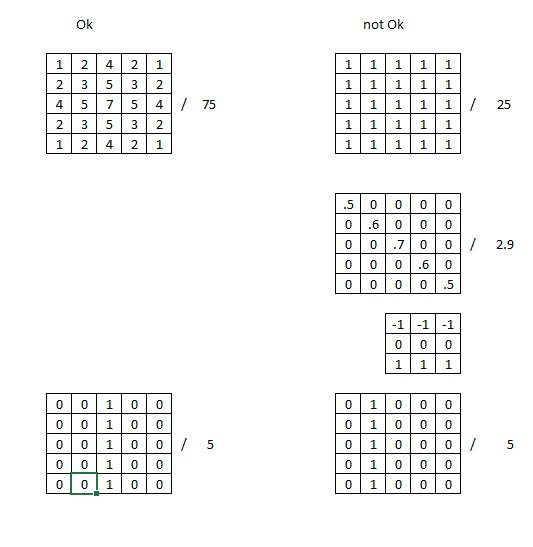